In [1]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

Fetched 1000 records
Columns in fetched data: Index(['femaDeclarationString', 'disasterNumber', 'state', 'declarationType',
       'declarationDate', 'fyDeclared', 'incidentType', 'declarationTitle',
       'ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared',
       'hmProgramDeclared', 'incidentBeginDate', 'incidentEndDate',
       'disasterCloseoutDate', 'tribalRequest', 'fipsStateCode',
       'fipsCountyCode', 'placeCode', 'designatedArea',
       'declarationRequestNumber', 'lastIAFilingDate', 'lastRefresh', 'hash',
       'id'],
      dtype='object')
Processed data:


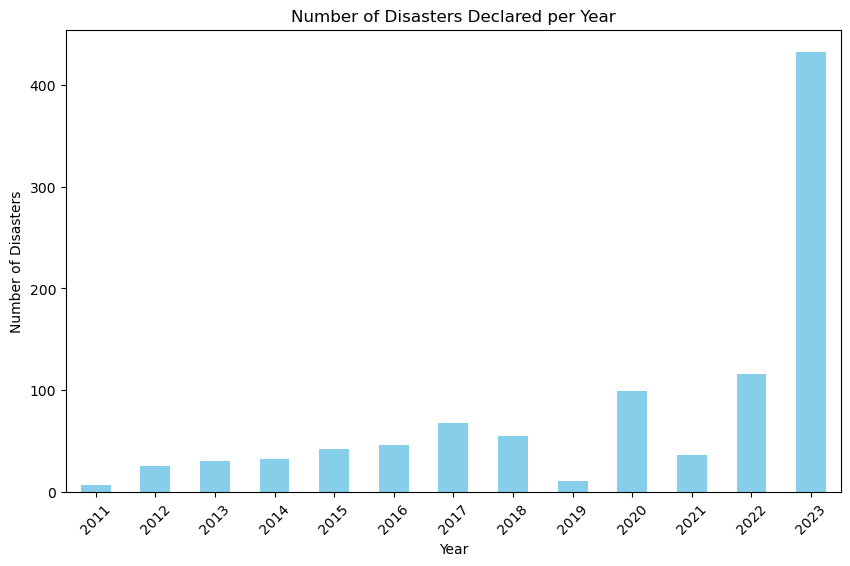

Top 10 States by Number of Disasters:
  State  Number of Disasters
0    CA                  179
1    KY                  111
2    WA                   78
3    TN                   73
4    FL                   71
5    OR                   49
6    SC                   42
7    MT                   37
8    TX                   36
9    NV                   24
Processed data saved to fema_disaster_declarations_processed.csv

Analysis complete.


In [5]:
# Fetch FEMA Disaster Data
def fetch_fema_disaster_data(start_date, end_date):
    base_url = "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries"
    filters = f"?$filter=declarationDate ge '{start_date}' and declarationDate le '{end_date}'"
    api_query = base_url + filters

    all_data = []
    while api_query:
        response = requests.get(api_query)
        if response.status_code != 200:
            break
        data = response.json()
        all_data.extend(data['DisasterDeclarationsSummaries'])
        api_query = data['metadata']['nextPageUrl'] if 'nextPageUrl' in data['metadata'] else None

    return pd.DataFrame(all_data)

# Process FEMA Data
def process_fema_data(df):
    # Convert date columns to datetime
    date_columns = ['declarationDate', 'incidentBeginDate', 'incidentEndDate']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

    # Fill missing values and drop irrelevant columns
    fill_values = {
        'fyDeclared': 0, 
        'declarationTitle': '', 
        'ihProgramDeclared': False, 
        'iaProgramDeclared': False, 
        'paProgramDeclared': False, 
        'hmProgramDeclared': False
    }
    if 'state' in df.columns:
        fill_values['state'] = ''

    df = df.fillna(fill_values)
    
    drop_columns = ['declarationTitle', 'ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']
    drop_columns = [col for col in drop_columns if col in df.columns]
    df = df.drop(columns=drop_columns)

    return df

# Analyze FEMA Data
def analyze_fema_data(df):
    # Plot the number of disasters declared each year
    df['year'] = df['declarationDate'].dt.year
    disasters_per_year = df.groupby('year').size()

    plt.figure(figsize=(10, 6))
    disasters_per_year.plot(kind='bar', color='skyblue')
    plt.title('Number of Disasters Declared per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Disasters')
    plt.xticks(rotation=45)
    plt.show()

# Rank by State
def rank_by_state(df):
    state_ranking = None

    if 'state' in df.columns:
        state_ranking = df['state'].value_counts().reset_index()
        state_ranking.columns = ['State', 'Number of Disasters']

    return state_ranking

# Usage
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fetch data
raw_data = fetch_fema_disaster_data(start_date, end_date)
print(f"Fetched {len(raw_data)} records")
print("Columns in fetched data:", raw_data.columns)

# Process data
processed_data = process_fema_data(raw_data)
print("Processed data:")

# Analyze data
analyze_fema_data(processed_data)

# Rank by state
state_ranking = rank_by_state(processed_data)

if state_ranking is not None:
    print("Top 10 States by Number of Disasters:")
    print(state_ranking.head(10))
else:
    print("State data not available.")

# # Save processed data to CSV
output_file = 'fema_disaster_declarations_processed.csv'
processed_data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

print("\nAnalysis complete.")


In [2]:
processed_data = pd.read_csv('../Weather/fema_disaster_declarations_processed.csv')

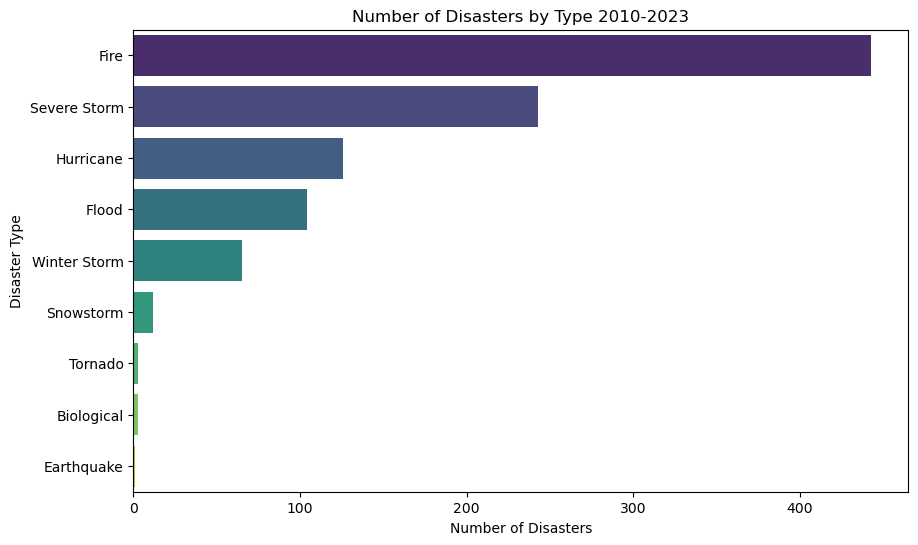

In [4]:
#rank by disaster type
def rank_by_disaster_type(df):
    disaster_type_ranking = df['incidentType'].value_counts().reset_index()
    disaster_type_ranking.columns = ['Disaster Type', 'Number of Disasters']
    return disaster_type_ranking

#plot disaster type
def plot_disaster_type(df):
    disaster_type_ranking = rank_by_disaster_type(df)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Number of Disasters', y='Disaster Type', data=disaster_type_ranking, palette='viridis')
    plt.title('Number of Disasters by Type 2010-2023')
    plt.xlabel('Number of Disasters')
    plt.ylabel('Disaster Type')
    plt.show()

plot_disaster_type(processed_data)

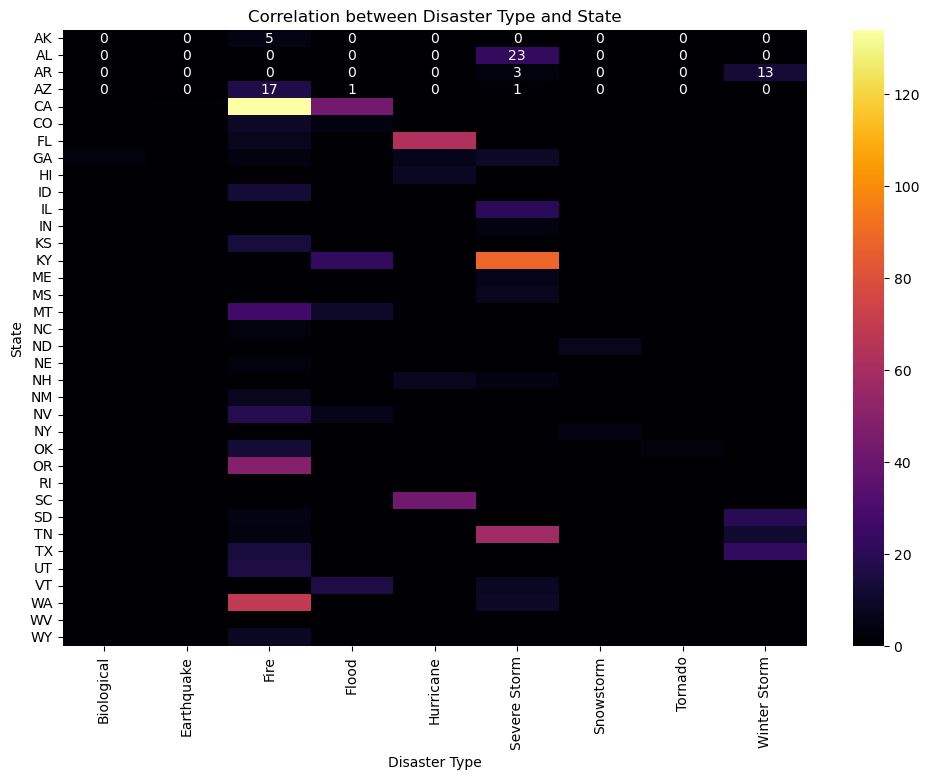

In [7]:
#correlation disaster type and state    
def correlation_disaster_type_state(df):
    cross_tab = pd.crosstab(df['state'], df['incidentType'])
    return cross_tab

#plot correlation disaster type and state
def plot_correlation_disaster_type_state(df):
    cross_tab = correlation_disaster_type_state(df)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, cmap='inferno', annot=True, fmt='d')
    plt.title('Correlation between Disaster Type and State')
    plt.xlabel('Disaster Type')
    plt.ylabel('State')
    plt.show()

plot_correlation_disaster_type_state(processed_data)

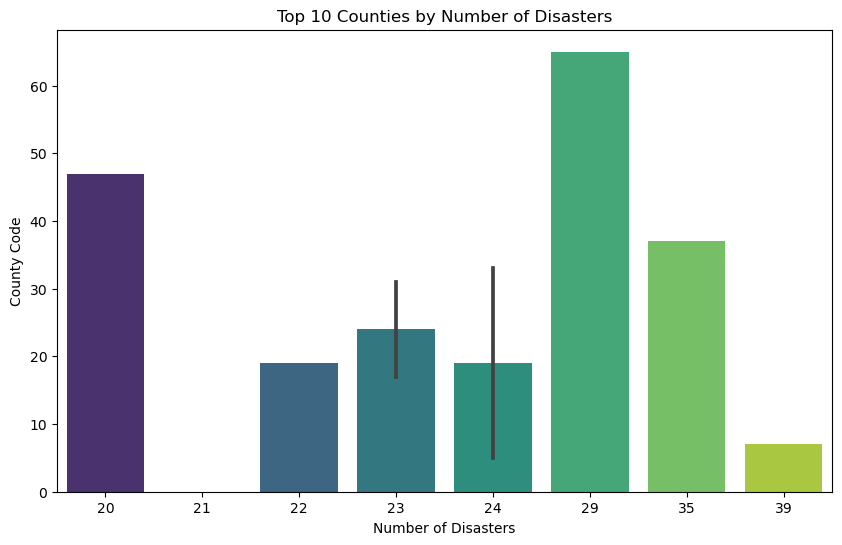

In [9]:
#ranking by county code
def rank_by_county_code(df):
    county_code_ranking = df['fipsCountyCode'].value_counts().reset_index()
    county_code_ranking.columns = ['County Code', 'Number of Disasters']
    return county_code_ranking

#plot results of ranking by county code
def plot_rank_by_county_code(df):
    county_code_ranking = rank_by_county_code(df)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Number of Disasters', y='County Code', data=county_code_ranking.head(10), palette='viridis')
    plt.title('Top 10 Counties by Number of Disasters')
    plt.xlabel('Number of Disasters')
    plt.ylabel('County Code')
    plt.show()

plot_rank_by_county_code(processed_data)